In [1]:
import os
import sys

import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import plot


In [2]:
import django
# for django async setting
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ['DJANGO_ALLOW_ASYNC_UNSAFE'] = 'true'
django.setup()

In [3]:
# my util functions
from ra_exploer.views import filterQuery
from utils.TR2_tools import tr2_score

In [4]:
query = {
    'LC': ['LCT-15-1098', 'SLC19V33', 'SLC20V87', '843001', 'ZIX-7054XX', 'N.A.'],
    'PI': ['ALL'],
    'Seal': ['ALL'],
}

vhr_df, vhr_mean_df = filterQuery(query, VHR)
adhesion_df, adhesion_mean_df = filterQuery(query, Adhesion)
lts_df, lts_mean_df = filterQuery(query, LowTemperatureStorage)
delta_angle_df, delta_angle_mean_df = filterQuery(
                query, DeltaAngle, 'lt')
pct_df, pct_mean_df = filterQuery(query, PressureCookingTest)
sealwvtr_df, sealwvtr_mean_df = filterQuery(query, SealWVTR)


In [9]:
sealwvtr_mean_df['configuration'].str.replace('N.A.', '', regex=False)

2       SWH25
0       7142T
1      723K1M
3        V386
Name: configuration, dtype: object

In [10]:
sealwvtr_mean_df

,item,LC,PI,Seal,Vender,value,configuration,score
2,Seal WVTR,N.A.,N.A.,SWH25,三井,281.0,N.A. N.A. SWH25,40.0
0,Seal WVTR,N.A.,N.A.,7142T,三井,250.0,N.A. N.A. 7142T,28.0
1,Seal WVTR,N.A.,N.A.,723K1M,三井,197.0,N.A. N.A. 723K1M,12.0
3,Seal WVTR,N.A.,N.A.,V386,三井,177.0,N.A. N.A. V386,4.0


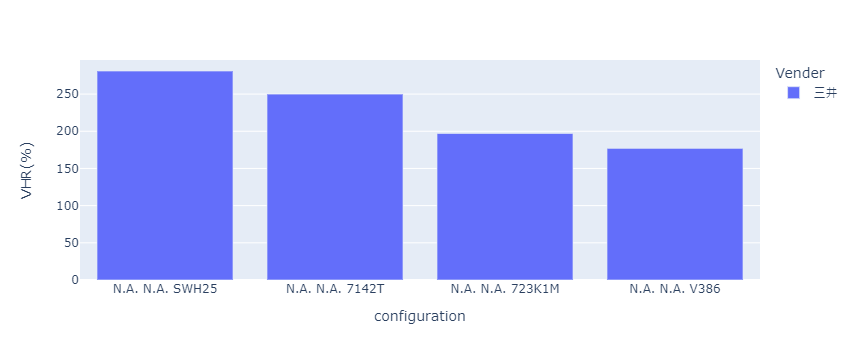

In [6]:
fig = px.bar(
    sealwvtr_mean_df,
    x='configuration',
    y='value',
    color='Vender',
    barmode='group',
    labels={
        'value': 'VHR(%)'
    }
)
fig.show()

In [5]:
df_LC = pd.DataFrame({'LC': ['LCT-15-1098', 'SLC19V33', 'LCT-19-580']})
df_PI = pd.DataFrame({'PI': ['RB005', 'RB205']})
df_seal = pd.DataFrame({'Seal': ['723K1M', '7142T', 'V386']})

In [6]:
df_LC_PI = df_LC.merge(df_PI, how='cross')
df = df_LC_PI.merge(df_seal, how='cross')

In [20]:
adhesion_mean_df['score'].sum()

163.0

In [21]:
def is_worth_df(df):
    return not(df.empty or (df['score'].sum() == 0))
if is_worth_df(adhesion_mean_df):
    adhesion_mean_df = adhesion_mean_df.groupby(by=['PI', 'Seal'], as_index=False).mean()
    df = df.merge(adhesion_mean_df[['PI', 'Seal', 'score']], on=['PI', 'Seal'], how='left').rename(columns={'score': 'Adhesion'})
if is_worth_df(delta_angle_mean_df):
    delta_angle_mean_df = delta_angle_mean_df.groupby(by=['LC', 'PI'], as_index=False).mean()
    df = df.merge(delta_angle_mean_df[['LC', 'PI', 'score']], on=['LC', 'PI'], how='left').rename(columns={'score': 'Δ angle'})
if is_worth_df(vhr_mean_df):
    vhr_mean_df = vhr_mean_df.groupby(by=['LC', 'PI', 'Seal'], as_index=False).mean()
    df = df.merge(vhr_mean_df[['LC', 'PI', 'Seal', 'score']], on=['LC', 'PI', 'Seal'], how='left').rename(columns={'score': 'VHR'})
if is_worth_df(lts_mean_df):
    lts_mean_df = lts_mean_df.groupby(by=['LC'], as_index=False).mean()
    df = df.merge(lts_mean_df[['LC', 'score']], on=['LC'], how='left').rename(columns={'score': 'LTS'})
if is_worth_df(pct_mean_df):
    pct_mean_df = pct_mean_df.groupby(by=['LC', 'PI', 'Seal'], as_index=False).mean()
    df = df.merge(pct_mean_df[['LC', 'PI', 'Seal', 'score']], on=['LC', 'PI', 'Seal'], how='left').rename(columns={'score': 'PCT'})
if is_worth_df(sealwvtr_mean_df):
    sealwvtr_mean_df = sealwvtr_mean_df.groupby(by=['Seal'], as_index=False).mean()
    df = df.merge(sealwvtr_mean_df[['Seal', 'score']], on=['Seal'], how='left').rename(columns={'score': 'Seal WVTR'})
            

In [34]:
list(df.columns[3:]) + ['Sum']

['Adhesion', 'VHR', 'LTS', 'PCT', 'Seal WVTR', 'Sum']

In [60]:
# df.info()
df_fill0 = df.fillna(0)
df_fill0['Sum'] = df_fill0[['Adhesion', 'VHR', 'LTS', 'PCT', 'Seal WVTR']].sum(axis=1)
df_fill0 = df_fill0.sort_values(by='Sum', ascending=False)

In [61]:
df_fill0[:10]

,LC,PI,Seal,Adhesion,Δ angle,VHR,LTS,PCT,Seal WVTR,Sum
14,LCT-19-580,RB005,V386,6.000000,1.0,0.0,37.0,0.0,37.0,80.000000
17,LCT-19-580,RB205,V386,4.333333,28.0,0.0,37.0,0.0,37.0,78.333333
0,LCT-15-1098,RB005,723K1M,7.750000,0.0,37.0,1.0,0.0,30.0,75.750000
12,LCT-19-580,RB005,723K1M,7.750000,1.0,0.0,37.0,0.0,30.0,74.750000
15,LCT-19-580,RB205,723K1M,2.666667,28.0,0.0,37.0,0.0,30.0,69.666667
8,SLC19V33,RB005,V386,6.000000,0.0,0.0,19.0,0.0,37.0,62.000000
11,SLC19V33,RB205,V386,4.333333,0.0,0.0,19.0,0.0,37.0,60.333333
13,LCT-19-580,RB005,7142T,8.000000,1.0,0.0,37.0,0.0,12.0,57.000000
6,SLC19V33,RB005,723K1M,7.750000,0.0,0.0,19.0,0.0,30.0,56.750000
5,LCT-15-1098,RB205,V386,4.333333,0.0,0.0,1.0,10.0,37.0,52.333333


In [62]:
df_fill0['Configuration'] = df_fill0['LC'] + ' ' + df_fill0['PI'] + ' ' + df_fill0['Seal']

In [67]:
ra_plot_df = df_fill0[:10] \
    .set_index('Configuration')[['Adhesion', 'VHR', 'LTS', 'PCT', 'Seal WVTR', 'Sum']] \
    .unstack() \
    .reset_index() \
    .rename(columns={'level_0': 'Item', 0: 'Score'})

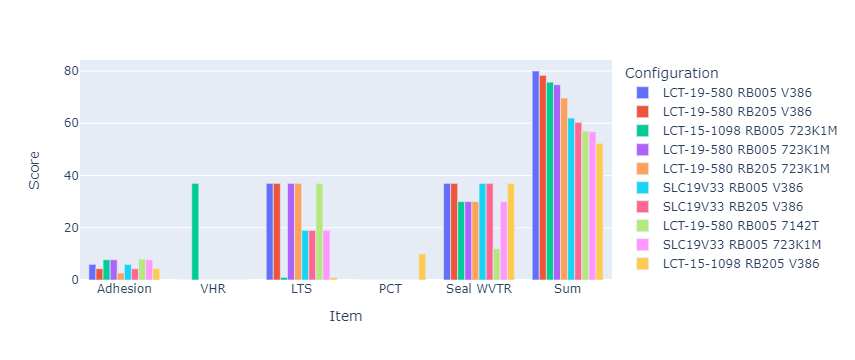

In [68]:
ra_fig = px.bar(
    ra_plot_df,
    x='Item',
    y='Score',
    color='Configuration',
    barmode='group'
)
ra_fig.show()

In [70]:
vhr_mean_df

,LC,PI,Seal,value,score
0,LCT-15-1098,RB005,7142T,83.9,15.0
1,LCT-15-1098,RB005,723K1M,89.0,37.0
2,LCT-15-1098,RB005,V386,80.5,1.0


In [75]:
pd.DataFrame({'PI': (list(Seal.objects.all().values_list('name', flat=True)))})

,PI
0,723K1M
1,7142T
2,V386
3,S-NP07
4,SNP07
5,N.A.
6,XN-5490H
7,SWH25
8,SSS42


In [7]:
query = {'LC': ['LCT-15-1098', 'SLC19V33', 'SLC20V87', '843001', 'ZIX-7054XX', 'N.A.'], 'PI': ['RB005', 'RB205', 'N.A.', 'SE-7492'], 'Seal': ['723K1M', '7142T', 'V386', 'S-NP07', 'SNP07', 
'N.A.', 'XN-5490H', 'SWH25', 'SSS42']}

In [8]:
df_LC = pd.DataFrame({'LC': query['LC']})
df_PI = pd.DataFrame({'PI': query['PI']})
df_seal = pd.DataFrame({'Seal': query['Seal']})

In [14]:
df_LC_PI = df_LC.merge(df_PI, how='cross')


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [10]:
from django.db.models import F

df = pd.DataFrame.from_records(OpticsLogTest.objects.filter(
    batch=Batch.objects.last(),
    cell_gap=F('liquidCrystal__designed_cell_gap'),
    v_percent='V99'
).values(
    "liquidCrystal__name",
    "lc_percent",
    "delta_e_ab_star",
    "response_time",
    "contrast_ratio",
    'remark',
))

In [11]:
df.iloc

,liquidCrystal__name,lc_percent,delta_e_ab_star,response_time,contrast_ratio,remark
0,LCT-15-1098,77.008,4.559364946,18.838267218,1809.0,Interpolation
1,SLC19V33,78.763,6.642051094,18.913386317,1466.5,Interpolation
2,SLC20V87,80.488,8.469812870,19.375287382,1571.5,Extrapolation
3,843001,78.616,3.574582943,18.803873728,1676.2,Interpolation
4,ZIX-7054XX,79.534,4.878003577,18.629047407,1496.4,Interpolation


In [37]:
df.iloc[]

decimal.Decimal

In [9]:
a = [0, 1, 2, 3, 4]
a[1:-1]

[1, 2, 3]